In [1]:
from __future__ import print_function, division
import os, bz2, json, time, sys, csv
from datetime import timedelta, datetime

import math
import collections
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats as stats

from matplotlib import pyplot as plt
from tqdm import tqdm

from util_read import engage_read, read_vids, engage_tweets_read, merge_engage_tweets, engage_metadata, compute_period_daily

In [2]:
plt.rcParams.update({'axes.labelsize': 20, 
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

In [3]:
# file_vids_filter_all = "/home/users/u6314203/pyProject/hip-popularity/data/engage16/filtered/vids_filter_all.csv" 
# engage_dataset_base = "/localdata/u6314203/dataset_engage16/tweeted_videos" 
# tweets_dataset_base = "/localdata/u6314203/dataset_tweets_engage/dataset_tweets_fixTZ"

file_vids_filter_all = "C:/Users/u6314203/pyProjects/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
engage_dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos"
tweets_dataset_base = "G:/MLCV dataset/engagement'16/tweets_dataset_fixTZ"

categories_eligible = ["autos", "comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

In [4]:
# vids from all category
vids_filter_all = read_vids(file_vids_filter_all)

merged_dataset = dict()
# engage_metadata = dict() 
for category in categories_eligible[1:3]:
    engage_dataset = engage_read(engage_dataset_base, category)
    tweets_dataset = engage_tweets_read(tweets_dataset_base, category)
    
    curr_merged = merge_engage_tweets(engage_dataset, tweets_dataset)
    merged_dataset.update(curr_merged)
    
print(f"Total size: {len(merged_dataset)}")

Vids(filtered) in each category:
autos:25712; comedy:31741; education:41191; entertainment:180128; film:43101; gaming:222236; howto:61027; music:118094; news:38249; people:222658; science:32278; sports:39649; travel:13112
Engage comedy size: 31519
Tweets comedy size: 31678
Merged size: 31456
Engage education size: 40311
Tweets education size: 41005
Merged size: 40126
Total size: 71582


In [5]:
timepoint = 90
pearsonr_vals = []
vids = []
for k, vals in merged_dataset.items():
    series_views = vals["viewCounts"][timepoint:]
    series_tweets = vals["tweets"][timepoint:]
    r, p = stats.pearsonr(series_views, series_tweets)
    pearsonr_vals.append([r,p,np.mean(series_views),np.mean(series_tweets)])
    vids.append(k)

df_pearsonr = pd.DataFrame(pearsonr_vals, columns=["r", "p", "daily views", "daily tweets"], index=vids)
df_pearsonr = df_pearsonr[[not x for x in np.isnan(df_pearsonr["r"])]]
pd.DataFrame.describe(df_pearsonr)

C:\Users\u6314203\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,r,p,daily views,daily tweets
count,28789.000000,2.878900e+04,28789.000000,28789.000000
mean,0.080718,4.049932e-01,641.455851,0.050705
std,0.145119,3.272255e-01,4179.540794,0.353854
min,-0.222911,1.309884e-243,0.580645,0.004219
25%,-0.012098,6.485717e-02,18.260000,0.005155
50%,0.045260,3.821668e-01,65.526882,0.010417
75%,0.129166,6.958622e-01,273.593137,0.027650
max,0.998287,1.000000e+00,354510.026455,40.184466


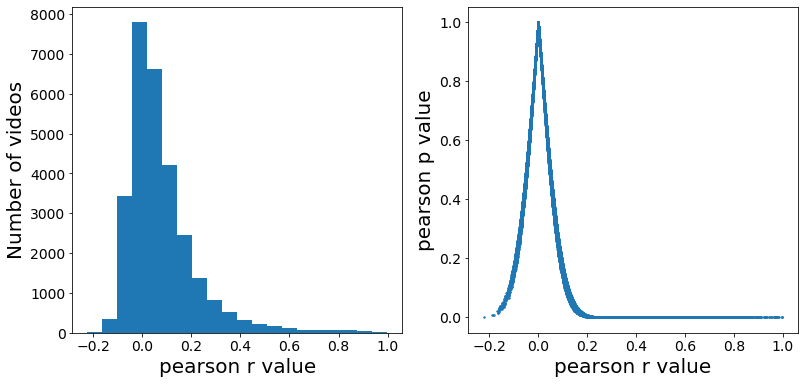

In [6]:
fig = plt.figure(figsize=(13, 6))

ax = fig.add_subplot(1,2,1)
n, bins, patches = ax.hist(df_pearsonr["r"], bins=20)
ax.set_xlabel("pearson r value")
ax.set_ylabel("Number of videos")

ax = fig.add_subplot(1,2,2)
ax.scatter(df_pearsonr["r"], df_pearsonr["p"], s=2)
ax.set_xlabel("pearson r value")
ax.set_ylabel("pearson p value")

fig.savefig("figs/longTermPearson1.pdf", bbox_inches='tight')

In [7]:
df_filter = df_pearsonr[df_pearsonr["p"]<=0.05]

pd.DataFrame.describe(df_filter)

,r,p,daily views,daily tweets
count,6691.000000,6.691000e+03,6691.000000,6691.000000
mean,0.280393,9.176929e-03,1296.158666,0.123224
std,0.164421,1.361161e-02,7538.063844,0.477644
min,-0.222911,1.309884e-243,2.292818,0.004237
25%,0.171916,1.839865e-06,28.933993,0.009804
50%,0.226606,1.196149e-03,143.168478,0.026738
75%,0.329425,1.441982e-02,776.257461,0.091324
max,0.998287,4.997525e-02,354510.026455,22.878788


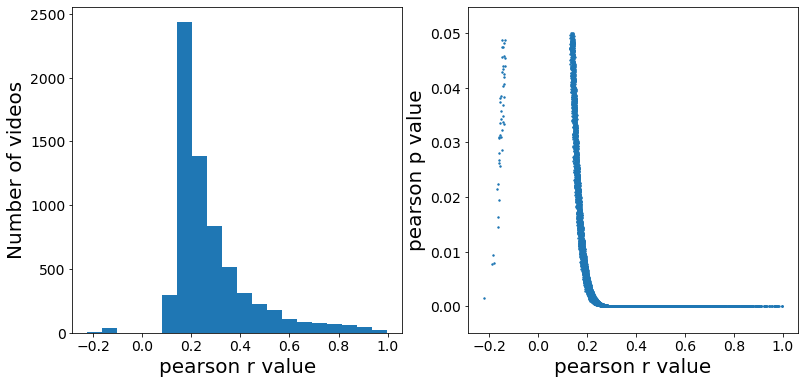

In [8]:
fig = plt.figure(figsize=(13, 6))

ax = fig.add_subplot(1,2,1)
n, bins, patches = ax.hist(df_filter["r"], bins=20)
ax.set_xlabel("pearson r value")
ax.set_ylabel("Number of videos")

ax = fig.add_subplot(1,2,2)
ax.scatter(df_filter["r"], df_filter["p"], s=2)
ax.set_xlabel("pearson r value")
ax.set_ylabel("pearson p value")

fig.savefig("figs/longTermPearson2.pdf", bbox_inches='tight')

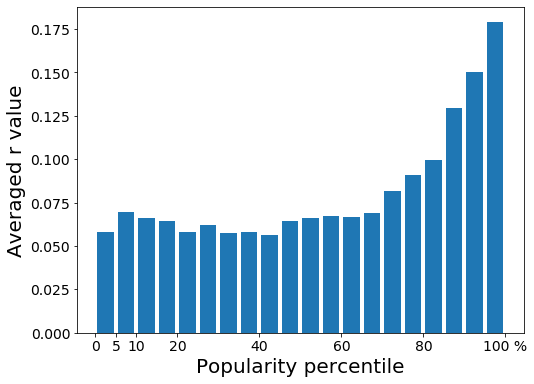

In [9]:
pd1 = df_pearsonr.sort_values(by=['daily views'])
edges = np.linspace(0, len(pd1.index), num=21)
pd1_bins = [pd1.iloc[int(edges[x]):int(edges[x+1]),:]["r"] for x in range(len(edges)-1)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.bar(list(range(20)), [np.mean(x) for x in pd1_bins])
ax.set_xticks(np.array([0, 1, 2, 4, 8, 12, 16, 20])-0.5)
ax.set_xticklabels(["0", "5", "10", "20", "40", "60", "80", "100 %"])
ax.set_xlabel("Popularity percentile")
ax.set_ylabel("Averaged r value")

fig.savefig("figs/rvalue_popularity.pdf", bbox_inches='tight')
pass

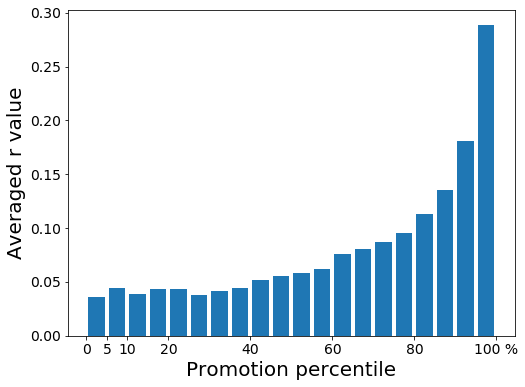

In [10]:
pd2 = df_pearsonr.sort_values(by=['daily tweets'])
edges = np.linspace(0, len(pd2.index), num=21)
pd2_bins = [pd2.iloc[int(edges[x]):int(edges[x+1]),:]["r"] for x in range(len(edges)-1)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.bar(list(range(20)), [np.mean(x) for x in pd2_bins])
ax.set_xticks(np.array([0, 1, 2, 4, 8, 12, 16, 20])-0.5)
ax.set_xticklabels(["0", "5", "10", "20", "40", "60", "80", "100 %"])
ax.set_xlabel("Promotion percentile")
ax.set_ylabel("Averaged r value")

fig.savefig("figs/rvalue_promotion.pdf", bbox_inches='tight')
pass